# 03. Velocity-based Pseudotime Estimation

This notebook will introduce the usage of velocity-based pseudotime estimation with vector field.

In [1]:
import pygot
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from tqdm import tqdm
import pandas as pd
import torch
import scvelo as scv
from scipy.stats import spearmanr
from pygot.tools.analysis import ProbabilityModel

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

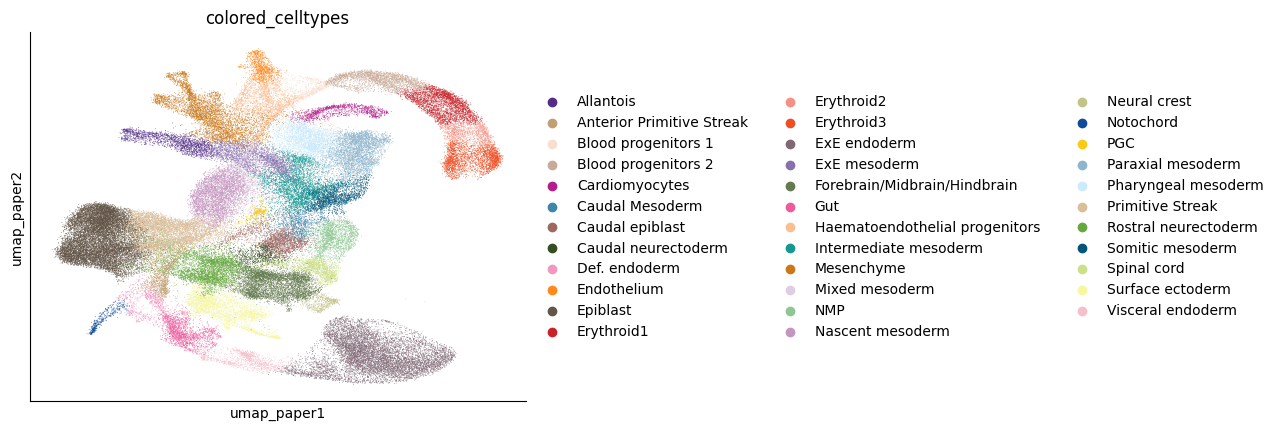

In [2]:
adata = sc.read('../../pygot_data/tutorial_data/GTL.h5ad')
cell_type_key = "colored_celltypes"
sc.pl.embedding(adata, basis="umap_paper", color=cell_type_key)

# Translate the temporal annotation into numeric format
adata.obs['stage_numeric'] = adata.obs['stage'].apply(lambda x: float(x[1:]))
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(np.float32)
#Extract only highly variable genes
adata = adata[:,adata.var['highly_variable']]

In [3]:
#Specify the temporal annotation, latent space
time_key = 'stage_numeric'
embedding_key = 'X_pca'
velocity_key = 'velocity_pca'


Note: Here we load the trained model to obtain velocity. 

In [4]:
model = torch.load('../../pygot_data/tutorial_data/GTL_model.pkl')
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model, time_key=time_key, embedding_key=embedding_key, 
                                                  A=adata.varm['PCs'].T, dr_mode='linear')

In [5]:
#compute velocity graph on the base of kNN graph
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space


## Pseudotime estimation

In [7]:
# VPT computation

if 'velocity_self_transition' in adata.obs.columns:
    del adata.obs['velocity_self_transition']
    del adata.obs['root_cells']
    del adata.obs['end_points']
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:15) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [8]:
# GOT-pseudotime computation
pm = ProbabilityModel()
pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key,  marginal=False, n_iters=500)
adata.obs['pseudotime'] = pm.estimate_pseudotime(adata)

Device: cuda


Density Loss 0.0000, Taylor Loss 0.0032: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.30it/s]


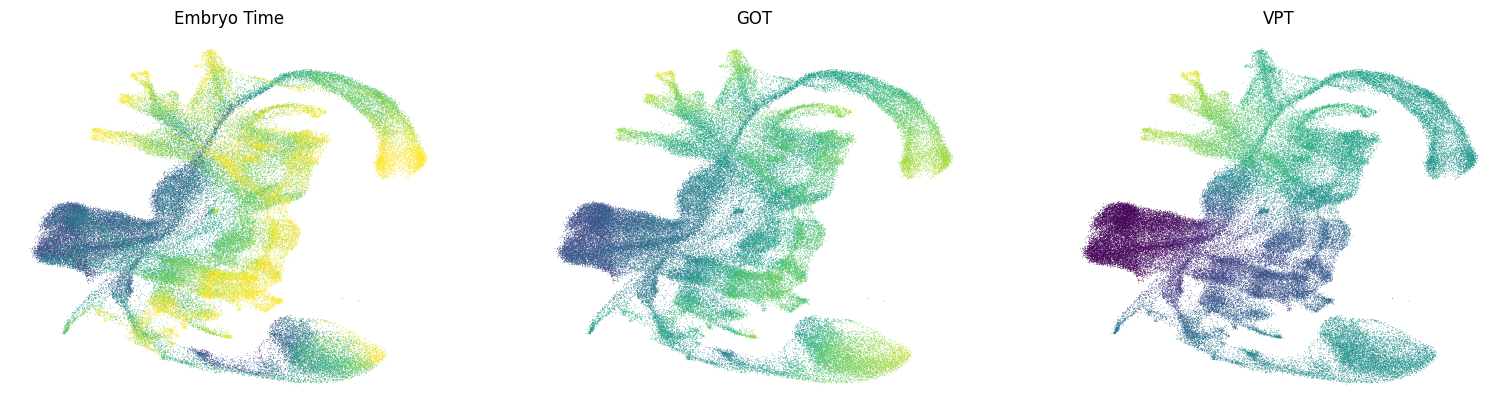

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(6.4*3 , 4.8  ))

sc.pl.embedding(adata, color=time_key, ax=axes[0],  title='Embryo Time', basis='umap_paper', show=False, colorbar_loc=None, frameon=False)
sc.pl.embedding(adata, color='pseudotime', title='GOT', ax=axes[1], basis='umap_paper',  show=False, colorbar_loc=None, frameon=False)
sc.pl.embedding(adata, color='velocity_pseudotime', title='VPT', ax=axes[2], basis='umap_paper', show=False, colorbar_loc=None, frameon=False)
plt.show()

In [10]:
# Use spearman correlation to quantify the accuracy of pseudtime
print('GOT Correlation:', spearmanr(adata.obs[time_key], adata.obs['pseudotime']))
print('VPT Correlation:', spearmanr(adata.obs[time_key], adata.obs['velocity_pseudotime']))

GOT Correlation: SignificanceResult(statistic=0.7991649323862425, pvalue=0.0)
VPT Correlation: SignificanceResult(statistic=0.5317310050442793, pvalue=0.0)
